# 2. List-based Simulations 

We detail the main datatype of GRANAD.

## Orbitals: A Recap

As already explained in the "Getting Started" Tutorial, Orbitals are the basic building blocks of orbital lists. Let's inspect the class

In [1]:
from granad import *
print(Orbital.__doc__)


    Represents the quantum state of an electron in an atom with specific properties.

    Attributes:
        position (jax.Array): The position of the orbital in space, initialized by default to a zero position.
                              This field is not used in hashing or comparison of instances.
        layer_index (Optional[int]): An optional index representing the layer of the orbital within its atom,
                                     may be None if not specified.
        tag (Optional[str]): An optional tag for additional identification or categorization of the orbital,
                             defaults to None.
        energy_level (Optional[int]): The principal quantum number indicating the energy level of the orbital,
                                      can be None.
        angular_momentum (Optional[int]): The quantum number representing the angular momentum of the orbital,
                                          optional and can be None.
        angular_mome

## Orbital lists

To group orbitals, we put them in a list. 

In [2]:
print(OrbitalList.__doc__)


    A class that encapsulates a list of orbitals, providing an interface similar to a standard Python list,
    while also maintaining additional functionalities for coupling orbitals and managing their relationships.

    The class stores orbitals in a wrapped Python list and handles the coupling of orbitals using dictionaries,
    where the keys are tuples of orbital identifiers (orb_id), and the values are the couplings (either a float
    or a function representing the coupling strength or mechanism between the orbitals).

    The class also stores simulation parameters like the number of electrons and temperature in a dataclass.
    
    The class computes physical observables (energies etc) lazily on the fly, when they are needed. If there is 
    a basis (either site or energy) to reasonably associate with a quantity, the class exposes quantity_x as an attribute
    for the site basis and quantity_e as an attribute for the energy basis. By default, all quantities are in site ba

So the docstring tells us that orbital lists

1. allow to couple orbitals 
2. store simulation parameters in a dataclass
3. compute physical observables lazily (it also talks about bases, but see the seperate tutorial).
4. let us simulate things

We will look at these remaining points below.

## Coupling orbitals

Say we want to create a stack of two graphene flakes.

In [3]:
flake = MaterialCatalog.get("graphene").cut_flake( Rectangle(10, 10) )

How do we create the second flake and stack it on top? First of all, we duplicate the existing flake

In [4]:
flake_shifted = MaterialCatalog.get("graphene").cut_flake( Rectangle(10, 10) )

We then inspect its orbitals.

In [5]:
print(flake_shifted)

List with 68 orbitals, 68 electrons.
[0] electrons excited from [0] to [0].
group id 2 : 68 orbitals


When the orbitals in a flake are instantiated, they are automatically assigned a group id that has not been in use before. This flake contains only one group for all pz orbitals in the flake. We can check this

In [6]:
print(flake_shifted.get_group_ids()) # the i-th entry is the group of the i-th orbital
print(flake_shifted.get_unique_group_ids()) # this is just jnp.unique on the previous array

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2]


So, we know that all orbitals in the flake have the same group_id. As such, we can group them and shift them together.

In [7]:
group_id_upper = flake_shifted.get_unique_group_ids()

# this shift will be applied to all orbitals with the same group => the flake is lifted in z-direction
flake_shifted.shift_by_vector( group_id_upper, [0,0,1] )

Creating the stack is easy now

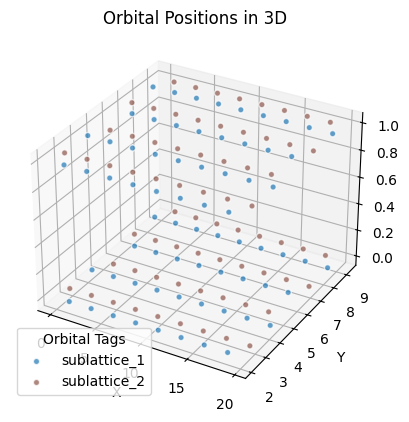

In [8]:
stack = flake + flake_shifted
stack.show_3d()

Okay, we have the geometry right, but what about the coupling? If we inspect the energies

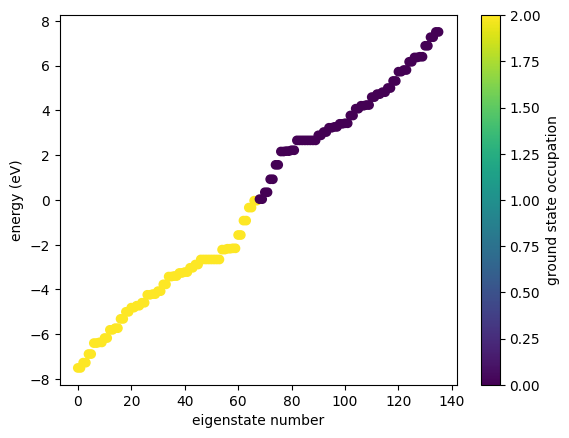

In [9]:
stack.show_energies()

We see that we get every point twice: the interlayer coupling is zero by default, so we have a two-fold degenerate spectrum. To lift this degeneracy, we need to couple the layers. We do this via a function depending on distance. Say, you want to couple only nearest neighbors in a layer with a strength of -2.66. Interlayer nearest neighbors are separated by a distance of 1 Angström. So, one way to express the coupling as a function is by a narrow gaussian around 1.0

In [10]:
def interlayer_hopping( distance ):
    return jnp.exp( -100*(distance - 1.0)**2 )

If the distance is (sufficiently close to) 1.0, we couple with -2.66, otherwise we don't couple. So, we want to couple two groups: the lower group of pz orbitals (the flake in the xy-plane) and the upper group. We do this like this:

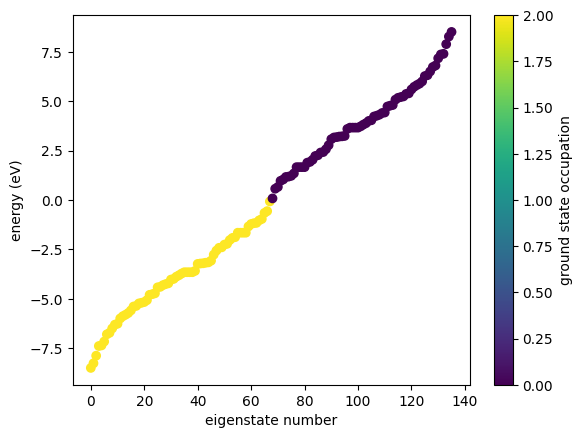

In [11]:
lower_id = flake.get_unique_group_ids()[0]
upper_id = flake_shifted.get_unique_group_ids()[0]
stack.set_groups_hopping( lower_id, upper_id, interlayer_hopping )
stack.show_energies()

The degeneracy is lifted! Consider now an adatom

In [12]:
lower_level = Orbital(tag="atom")
upper_level = Orbital(tag="atom")
atom = OrbitalList([lower_level, upper_level])
print(atom)

List with 2 orbitals, 2 electrons.
[0] electrons excited from [0] to [0].
group id 3 : 1 orbitals
group id 4 : 1 orbitals


For now, we have two electrons. We learn how to change this below. Each orbital has its own group_id. Don't change these, GRANAD handles these by default. We want to set energies of this adatom, i.e. its hamiltonian. If we just want a TLS with energies $\pm 0.5$, we have a $2x2$ matrix, where H[0,0] = -0.5, and H[1,1] = 0.5. We can set the hamiltonian elements directly

In [13]:
atom.set_hamiltonian_element( 0, 0, -0.5)
atom.set_hamiltonian_element( 1, 1, 0.5) 
print(atom.hamiltonian)

[[-0.5+0.j  0. +0.j]
 [ 0. +0.j  0.5+0.j]]


We can also set the elements by directly referencing the orbitals

In [14]:
atom.set_hamiltonian_element( upper_level, upper_level, 0.8)
print(atom.hamiltonian)

[[-0.5+0.j  0. +0.j]
 [ 0. +0.j  0.8+0.j]]


You can do the same thing for any element of the graphene flake btw. Talking about it, let's couple the atom to it. First, we combine the lists

In [15]:
stack_with_atom = stack + atom

Now, we move the atom somewhere in between the two flakes

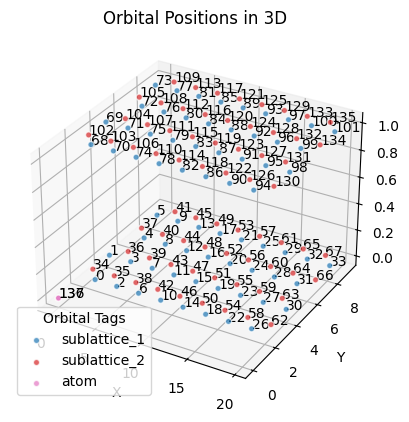

In [16]:
stack_with_atom.show_3d( show_index = True )

We pick two indices we like and put the atom in between. To move all orbitals on the atom, we use the tag we just defined.

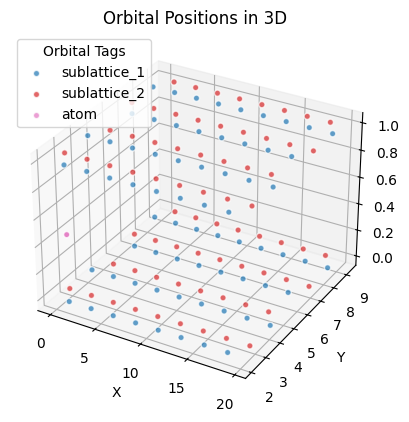

In [17]:
new_atom_position = stack_with_atom[0].position + jnp.array( [0,0,0.5] )
stack_with_atom.set_position("atom", position = new_atom_position)
stack_with_atom.show_3d()

Now, we look at the energies

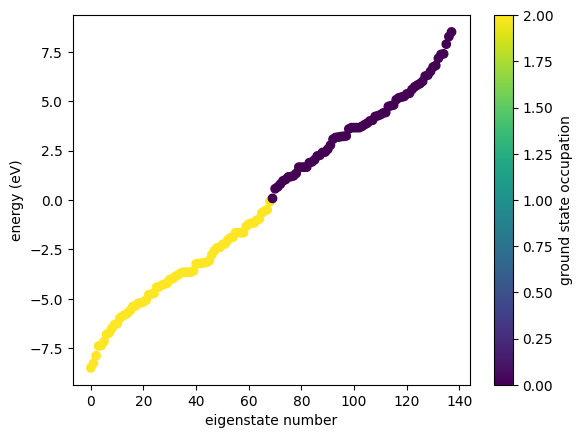

In [18]:
stack_with_atom.show_energies()

Not much of a change, but the reason is that we forgot to couple the atom to the flakes. So let's do that. We couple it just to its nearest neighbors.

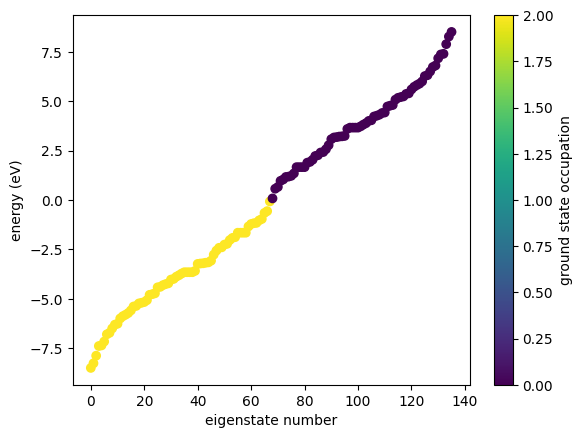

In [19]:
stack_with_atom.set_hamiltonian_element( lower_level, 0, 0.3 ) # we can even mix orbitals and indices
stack_with_atom.set_hamiltonian_element( upper_level, 0, 0.3 )

stack_with_atom.set_hamiltonian_element( upper_level, 64, 0.3 )
stack_with_atom.set_hamiltonian_element( upper_level, 64, 0.3 )
stack.show_energies()

Setting coulomb elements works analogously. To wrap up, we can couple by 

1. setting matrix elements indexing via orbitals or their list indices
2. setting coupling functions via group ids (you can also pass orbitals to these functions, but the behavior is a bit weirder).

## Simulation Parameters

Let's revisit the adatom we just built.

In [20]:
print(atom)

List with 2 orbitals, 2 electrons.
[0] electrons excited from [0] to [0].
group id 3 : 1 orbitals
group id 4 : 1 orbitals


We have two electrons, but a traditional TLS should only have one. We can do this like that

In [21]:
atom.set_electrons( atom.electrons - 1 )
print(atom)

List with 2 orbitals, 1 electrons.
[0] electrons excited from [0] to [0].
group id 3 : 1 orbitals
group id 4 : 1 orbitals


This looks better. Let's excite the transition (in our lingo, this is HOMO-LUMO)

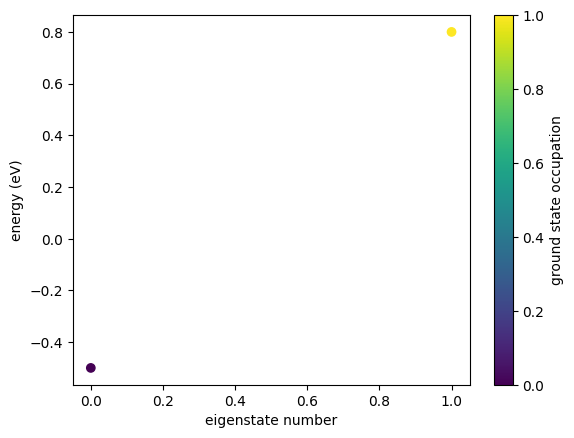

In [22]:
atom.set_excitation( 0, 1, 1)
atom.show_energies()

This works. Let's now combine it with another TLS

In [23]:
a = Orbital(tag="atom2")
b = Orbital(tag="atom2")
atom2 = OrbitalList([a, b])

atoms = atom + atom2
print(atoms.energies)
print(atoms)

[-0.5  0.   0.   0.8]
List with 4 orbitals, 4 electrons.
[0] electrons excited from [0] to [0].
group id 3 : 1 orbitals
group id 4 : 1 orbitals
group id 5 : 1 orbitals
group id 6 : 1 orbitals


WAIT! We are back to 2 + 2 = 4 electrons, i.e. one per orbital? Why is this? The reason is that addition for orbital lists is defined as, schematically

1. orb1 + orb2 = [orb1, orb2]
2. coupling1 + coupling2 = [coupling1, coupling2]
3. param1 + param2  = default_params

This might change in the future allowing you to define your own addition for all orbital list attributes. For now, we need to reset to the correct orbital number manually

In [24]:
atoms.set_electrons( atoms.electrons - 1)

Another peculiarity of orbital lists is: they can contain each orbital only one time. So, if you try:

In [25]:
# updated_stack = stack_with_atom + atoms

This will fail, because stack_with_atom already contains the atom contained in atoms. Admittedly, this is weird.

If you are interested in the simulation parameters

In [26]:
print(SimulationParams.__doc__)


    A data class for storing parameters necessary for running a simulation involving electronic states and transitions.

    Attributes:
        from_state (jax.Array): An array where each element is the index of an electronic state from which
                                electrons are excited. Defaults to an array containing a single zero.
        to_state (jax.Array): An array where each element is the index of an electronic state to which
                              electrons are excited. Defaults to an array containing a single zero.
        excited_electrons (jax.Array): An array where each element indicates the number of electrons excited
                                       between the corresponding states in `from_state` and `to_state`.
                                       Defaults to an array containing a single zero.
        eps (float): Numerical precision used for identifying degenerate eigenstates. Defaults to 1e-5.
        beta (float): Inverse temperature param

So, they encapsulate the state of the simulation. Just remember to set them directly before you simulate.

## Lazy computation

This is quickly explained: we have used it all the time!

In [27]:
atom.set_hamiltonian_element(0,0,0.0) # doesnt compute anything
atom.set_hamiltonian_element(0,0,1.0) # still, nothing computed
atom.energies # now, we need to compute

Array([0.8, 1. ], dtype=float64)

## Simulations

Simulations don't change anything about the orbitals, so we can do the same time propagation with two different relaxation rates etc. The only methods that change anything about the list explicitly tell you so by starting with "set".